# Installation

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
import os
import sklearn
import tensorflow as tf

plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "serif"

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss, RocCurveDisplay, roc_curve, auc


# **Read Data**

In [2]:
# Read a text file and transform it into a pandas dataframe
def read_txt_to_dataframe(file_path):
    try:
        # Read the contents of the file
        with open(file_path, 'r') as file:
            data = file.read()

        # Remove "<" and ">" symbols using string replace
        data = data.replace('<', '').replace('>', '')

        # Use StringIO to read the modified data into a DataFrame without changing the original file
        modified_file = StringIO(data)

        # Read the CSV data into a DataFrame
        df = pd.read_csv(modified_file)
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None

# Convert some columns into datetime objects
def convert_to_time_series(df):
    # Convert the 'DTYYYYMMDD' column to a datetime object
    df['DTYYYYMMDD'] = pd.to_datetime(df['DTYYYYMMDD'], format='%Y%m%d')
    
    # Create a weekly time lag column
    df['WEEK'] = df['DTYYYYMMDD'].dt.isocalendar().week
    
    # Convert the 'TIME' column to a datetime object
    df['TIME'] = pd.to_datetime(df['TIME'].astype(str).str.zfill(6), format='%H%M%S').dt.time

    # Combining the 'DTYYYYMMDD' and 'TIME' columns into a single 'DATE' column
    df['DATE'] = pd.to_datetime(df['DTYYYYMMDD'].astype(str) + ' ' + df['TIME'].astype(str))

    # Drop the 'DTYYYYMMDD' and 'TIME' columns
    df.drop(columns=['DTYYYYMMDD', 'TIME'], inplace=True)

    return df

In [3]:
# Initialize empty dataframes
bp_dia_df = pd.DataFrame()
bp_min_df = pd.DataFrame()

# Loop through the files in the "Data" folder
for file_name in ["bp1dia.txt", "bp1min.txt"]:
  file_path = os.path.join('datos', file_name)
  
  # Check if the file name ends with "dia.txt"
  if file_name.endswith('dia.txt'):
    temp_df = read_txt_to_dataframe(file_path)
    temp_df = convert_to_time_series(temp_df)
    bp_dia_df = pd.concat([bp_dia_df, temp_df], ignore_index=True)
  
  # Check if the file name ends with "min.txt"
  elif file_name.endswith('min.txt'):
    temp_df = read_txt_to_dataframe(file_path)
    temp_df = convert_to_time_series(temp_df)
    bp_min_df = pd.concat([bp_min_df, temp_df], ignore_index=True)

bp_dia_df.drop(['TICKER', 'PER', 'OPENINT', 'WEEK'], axis=1, inplace=True)
bp_min_df.drop(['TICKER', 'PER', 'OPENINT', 'WEEK'], axis=1, inplace=True)

# **Classification**

The goal is to classify whether an asset will increase by at least 5% in the next 6 months or not

## Feature selection

In [4]:
# Copy the dataset
bp_dia_df_classification = bp_dia_df.copy()

# Define the threshold: 5%
threshold = 0.05

# Create the target variable
bp_dia_df_classification['GROWTH'] = ((bp_dia_df_classification['CLOSE'].shift(-180) / bp_dia_df_classification['CLOSE']) - 1 > threshold).astype(int)  # 180 days ≈ 6 months

# Drop rows with NaN due to shift
bp_dia_df_classification = bp_dia_df_classification.dropna()

# Add features
bp_dia_df_classification['CHANGE'] = bp_dia_df_classification['CLOSE'] - bp_dia_df_classification['OPEN']
bp_dia_df_classification['EVOLUTION'] = bp_dia_df_classification['OPEN'] - bp_dia_df_classification['CLOSE'].shift(1)
bp_dia_df_classification['BULLISH'] = (bp_dia_df_classification['CLOSE'] > bp_dia_df_classification['OPEN']).astype(int)

# Create lag features (for the last 4 candlesticks)
lag_features = ['BULLISH', 'CHANGE', 'EVOLUTION']
num_lags = 4

for lag in range(1, num_lags + 1):
    for feature in lag_features:
        bp_dia_df_classification[f'{feature}_lag{lag}'] = bp_dia_df_classification[feature].shift(lag)

# Drop rows with NaNs resulting from lagging
bp_dia_df_classification = bp_dia_df_classification.dropna()

# Extract cyclical features
# Year, month, day, hour, minute, second
bp_dia_df_classification['year'] = bp_dia_df_classification['DATE'].dt.year
bp_dia_df_classification['month'] = bp_dia_df_classification['DATE'].dt.month
bp_dia_df_classification['day'] = bp_dia_df_classification['DATE'].dt.day

# Cyclical encoding for month, day, hour, minute, second
bp_dia_df_classification['month_sin'] = np.sin(2 * np.pi * bp_dia_df_classification['month'] / 12)
bp_dia_df_classification['month_cos'] = np.cos(2 * np.pi * bp_dia_df_classification['month'] / 12)

bp_dia_df_classification['day_sin'] = np.sin(2 * np.pi * bp_dia_df_classification['day'] / 31)  # 31 days in most months
bp_dia_df_classification['day_cos'] = np.cos(2 * np.pi * bp_dia_df_classification['day'] / 31)

# Convert 'DATE' to numeric
bp_dia_df_classification['ordinal_date'] = bp_dia_df_classification['DATE'].map(lambda x: x.toordinal())

# Drop original datetime columns
bp_dia_df_classification.drop(columns=['DATE', 'year', 'month', 'day'], inplace=True)

## Models and evaluation

In [5]:
# Split into training and testing
X = bp_dia_df_classification.drop(columns=['GROWTH', 'CLOSE'])  # Features
y = bp_dia_df_classification['GROWTH']                          # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

### Logistic regression

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       981
           1       1.00      0.00      0.01       248

    accuracy                           0.80      1229
   macro avg       0.90      0.50      0.45      1229
weighted avg       0.84      0.80      0.71      1229

CONFUSION MATRIX:
 [[981   0]
 [247   1]]

ROC-AUC: 0.49
Accuracy: 0.80
Recall: 0.00
Precision: 1.00
F1 Score: 0.01
Log Loss: 0.55


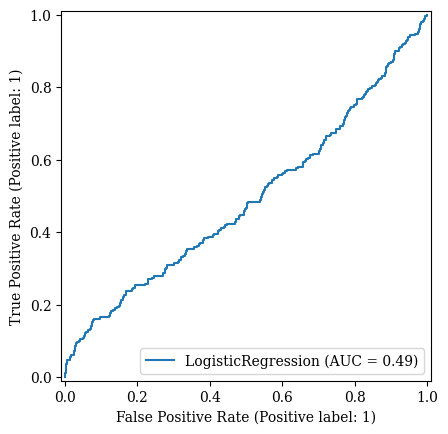

In [6]:
# Initialize the model
clf = LogisticRegression(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Predict on validation set
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_test_pred))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_test_pred))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_test_prob):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")
print(f"Log Loss: {log_loss(y_test, y_test_prob):.2f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

#### Grid search

Best parameters: {'C': 0.01, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       981
           1       0.00      0.00      0.00       248

    accuracy                           0.80      1229
   macro avg       0.40      0.50      0.44      1229
weighted avg       0.64      0.80      0.71      1229

CONFUSION MATRIX:
 [[981   0]
 [248   0]]

ROC-AUC: 0.47
Accuracy: 0.80
Recall: 0.00
Precision: 0.00
F1 Score: 0.00
Log Loss: 0.54


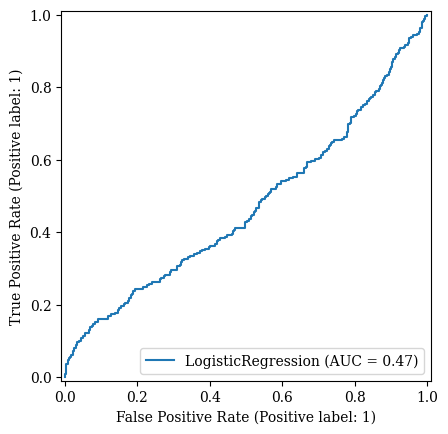

In [7]:
# Define the grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Initialize the model
clf = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid.best_params_}")

# Apply logistic regression with the best parameters
clf = LogisticRegression(**grid.best_params_, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_test_pred))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_test_pred))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_test_prob):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")
print(f"Log Loss: {log_loss(y_test, y_test_prob):.2f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

### Random Forest

              precision    recall  f1-score   support

           0       0.89      0.65      0.75       981
           1       0.33      0.68      0.44       248

    accuracy                           0.66      1229
   macro avg       0.61      0.67      0.60      1229
weighted avg       0.78      0.66      0.69      1229

CONFUSION MATRIX:
 [[638 343]
 [ 79 169]]

ROC-AUC: 0.68
Accuracy: 0.66
Recall: 0.68
Precision: 0.33
F1 Score: 0.44
Log Loss: 0.66


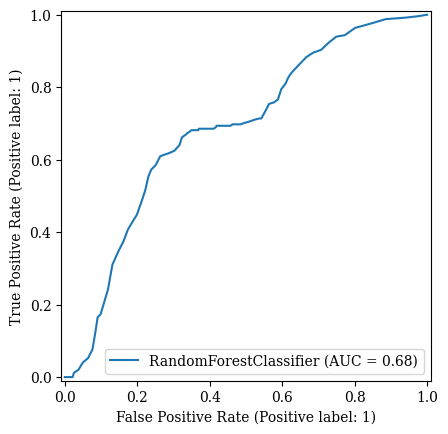

In [8]:
# Train a Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_test_pred))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_test_pred))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_test_prob):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")
print(f"Log Loss: {log_loss(y_test, y_test_prob):.2f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

#### Grid search

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.89      0.65      0.75       981
           1       0.33      0.69      0.45       248

    accuracy                           0.66      1229
   macro avg       0.61      0.67      0.60      1229
weighted avg       0.78      0.66      0.69      1229

CONFUSION MATRIX:
 [[635 346]
 [ 78 170]]

ROC-AUC: 0.67
Accuracy: 0.66
Recall: 0.69
Precision: 0.33
F1 Score: 0.45


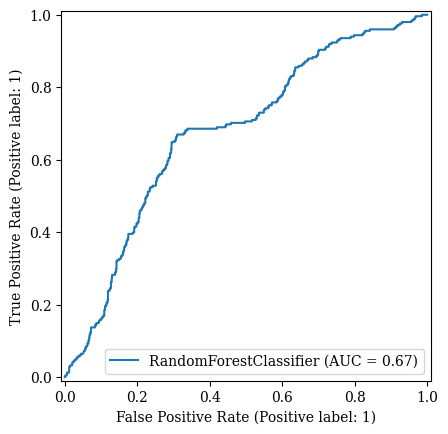

In [9]:
# Define the grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid.best_params_}")

# Apply Random Forest with the best parameters
clf = RandomForestClassifier(**grid.best_params_, random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_test_pred))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_test_pred))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_test_prob):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)

### KNN

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       981
           1       0.18      0.10      0.13       248

    accuracy                           0.73      1229
   macro avg       0.49      0.49      0.48      1229
weighted avg       0.67      0.73      0.70      1229

CONFUSION MATRIX:
 [[873 108]
 [224  24]]

ROC-AUC: 0.47
Accuracy: 0.73
Recall: 0.10
Precision: 0.18
F1 Score: 0.13
Log Loss: 3.12


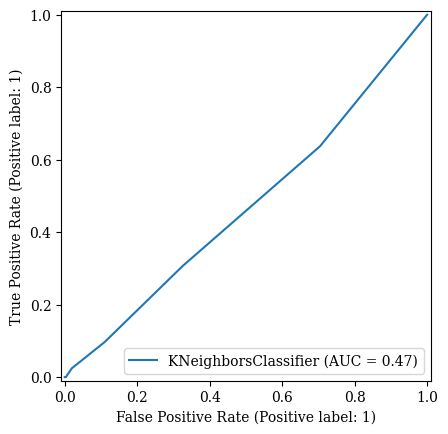

In [10]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

# Train the model
knn.fit(X_train, y_train)

# Predict on validation set
y_test_pred = knn.predict(X_test)
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_test_pred))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_test_pred))
print(f"\nROC-AUC: {roc_auc_score(y_test, y_test_prob):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")
print(f"Log Loss: {log_loss(y_test, y_test_prob):.2f}")

# Plot ROC curve
RocCurveDisplay.from_estimator(knn, X_test, y_test)

### LSTM

In [11]:
# Assuming X and y are your feature and target DataFrames
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
timesteps = 10  # Choose an appropriate timestep (e.g., last 10 days)

def reshape_for_lstm(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):        sequences.append(data[i:i+timesteps])
    return np.array(sequences)

X_train_seq = reshape_for_lstm(X_train_scaled, timesteps)
X_test_seq = reshape_for_lstm(X_test_scaled, timesteps)

# Ensure the target values are aligned correctly with the sequences
y_train_seq = y_train[timesteps:].values  # Align target with sequences
y_test_seq = y_test[timesteps:].values

# Confirm the shapes of the data
print(f'X_train_seq shape: {X_train_seq.shape}')
print(f'X_test_seq shape: {X_test_seq.shape}')
print(f'y_train_seq shape: {y_train_seq.shape}')
print(f'y_test_seq shape: {y_test_seq.shape}')


X_train_seq shape: (11048, 10, 24)
X_test_seq shape: (1219, 10, 24)
y_train_seq shape: (11048,)
y_test_seq shape: (1219,)


In [12]:
# Count the number of values from each class in the training set
unique, counts = np.unique(y_train_seq, return_counts=True)

# Calculate the class weights
class_weights = {i: y_train_seq.shape[0] / count for i, count in enumerate(counts)}

num_classes = 2 # Binary classification

# Define the LSTM model for classification
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),  # Fully connected layer for learning patterns
    Dense(num_classes, activation='sigmoid')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Early stopping callback
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

# Fit the model
history = model.fit(
    X_train_seq, y_train_seq, 
    validation_data=(X_test_seq, y_test_seq), 
    epochs=50, 
    batch_size=32, 
    class_weight=class_weights,
 #   callbacks=[early_stopping]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,890 (507.38 KB)

 Trainable params: 129,890 (507.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.6073 - loss: 1.3184 - val_accuracy: 0.6218 - val_loss: 0.7233
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7044 - loss: 1.1714 - val_accuracy: 0.5414 - val_loss: 1.2567
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7337 - loss: 1.0339 - val_accuracy: 0.7449 - val_loss: 0.6372
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7956 - loss: 0.8697 - val_accuracy: 0.6850 - val_loss: 0.9485
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8582 - loss: 0.6437 - val_accuracy: 0.7596 - val_loss: 0.6589
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8906 - loss: 0.5271 - val_accuracy: 0.7186 - val_loss: 0.9058
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9175 - loss: 0.4231 - val_accuracy: 0.7170 - val_loss: 0.9322
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9406 - loss: 0.3147 - 

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
              precision    recall  f1-score   support

           0       0.86      0.66      0.75       971
           1       0.31      0.58      0.40       248

    accuracy                           0.65      1219
   macro avg       0.59      0.62      0.58      1219
weighted avg       0.75      0.65      0.68      1219

CONFUSION MATRIX:
 [[645 326]
 [103 145]]

ROC-AUC: 0.67
Accuracy: 0.65
Recall: 0.58
Precision: 0.31
F1 Score: 0.40
Log Loss: 1.07


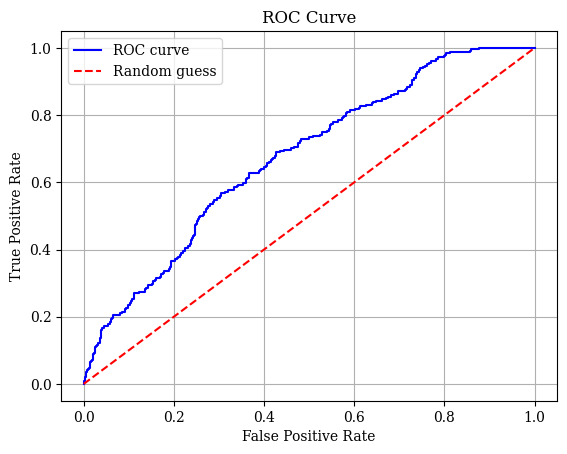

In [13]:
# Evaluate the model
y_test_prob = model.predict(X_test_seq)
y_test_pred_seq = np.argmax(y_test_prob, axis=1)

print(classification_report(y_test_seq, y_test_pred_seq))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test_seq, y_test_pred_seq))
print(f"\nROC-AUC: {roc_auc_score(y_test_seq, y_test_prob[:, 1]):.2f}")
print(f"Accuracy: {accuracy_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"Recall: {recall_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"Precision: {precision_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"F1 Score: {f1_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"Log Loss: {log_loss(y_test_seq, y_test_prob):.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_seq, y_test_prob[:, 1])

plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

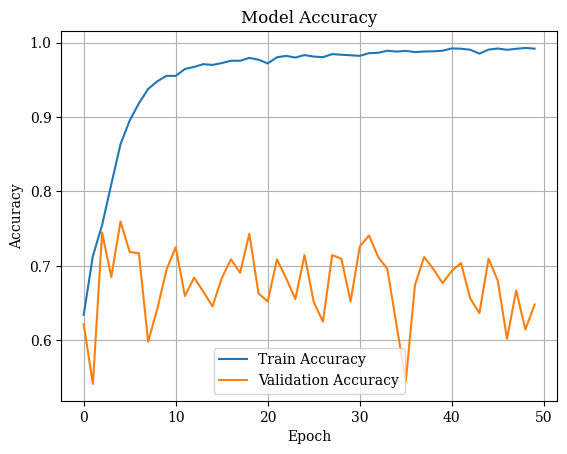

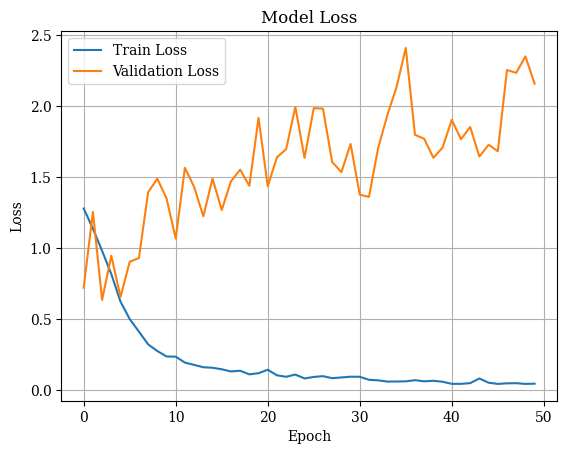

In [14]:
# Model accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

# Model loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()

#### Ablation studies

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,890 (507.38 KB)

 Trainable params: 129,890 (507.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.6118 - loss: 1.3075 - val_accuracy: 0.5972 - val_loss: 0.8881
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.7127 - loss: 1.0931 - val_accuracy: 0.6661 - val_loss: 0.7694
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8079 - loss: 0.8413 - val_accuracy: 0.6965 - val_loss: 0.6500
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.8626 - loss: 0.6074 - val_accuracy: 0.6103 - val_loss: 1.2941
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9049 - loss: 0.4545 - val_accuracy: 0.7637 - val_loss: 0.6869
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9364 - loss: 0.3288 - val_accuracy: 0.7071 - val_loss: 0.9801
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9453 - loss: 0.2682 - val_accuracy: 0.7416 - val_loss: 0.9416
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9563 - loss: 0.2218 - va

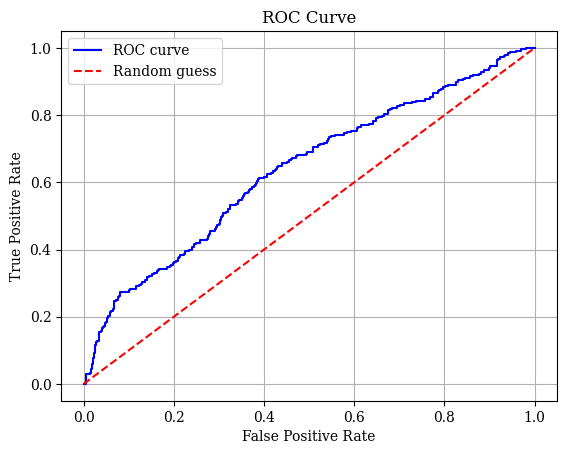

In [15]:
# Ablaion studies: removing the dropout layers

num_classes = 2 # Binary classification

# Define the LSTM model for classification
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64),
    Dense(32, activation='relu'),  # Fully connected layer for learning patterns
    Dense(num_classes, activation='sigmoid')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Fit the model
history = model.fit(
    X_train_seq, y_train_seq, 
    validation_data=(X_test_seq, y_test_seq), 
    epochs=50, 
    batch_size=32, 
    class_weight=class_weights,
 #   callbacks=[early_stopping]
)

# Evaluate the model
y_test_prob = model.predict(X_test_seq)
y_test_pred_seq = np.argmax(y_test_prob, axis=1)

print(classification_report(y_test_seq, y_test_pred_seq))
print('CONFUSION MATRIX:\n', confusion_matrix(y_test_seq, y_test_pred_seq))
print(f"\nROC-AUC: {roc_auc_score(y_test_seq, y_test_prob[:, 1]):.2f}")
print(f"Accuracy: {accuracy_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"Recall: {recall_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"Precision: {precision_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"F1 Score: {f1_score(y_test_seq, y_test_pred_seq):.2f}")
print(f"Log Loss: {log_loss(y_test_seq, y_test_prob):.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_seq, y_test_prob[:, 1])

plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

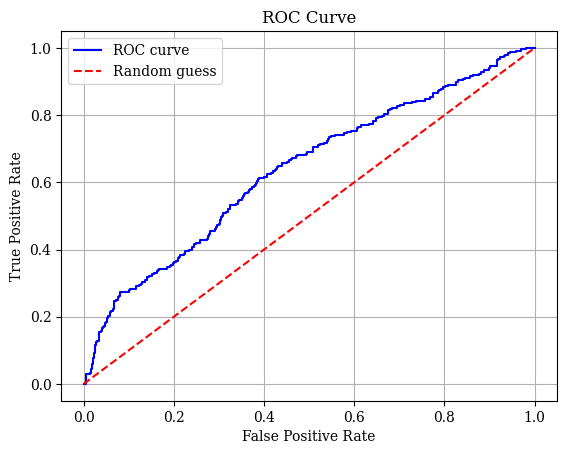

In [16]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_seq, y_test_prob[:, 1])

plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()